In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [12]:
boundaries

array([[   0,   15],
       [  15,   30],
       [  30,   31],
       ...,
       [6260, 6272],
       [6272, 6284],
       [6284, 6296]], shape=(512, 2))

Loaded 6296 total windows across 512 sessions.

Analyzing Session 5:
Indices in global array: 55 to 70
Number of windows in this session: 15

Details for Window #10 inside Session 5:
Model Predicted (Max for next 30s): 97170776.00
Actual Max that occurred: 84892200.00
The next 30 seconds of raw traffic values were:
[7.1284000e+04 0.0000000e+00 0.0000000e+00 9.1600006e+02 2.8144272e+07
 2.9260984e+07 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1463776e+07
 8.4892200e+07 4.7644176e+07 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.3420988e+07 7.6951392e+07 1.9561321e+06]


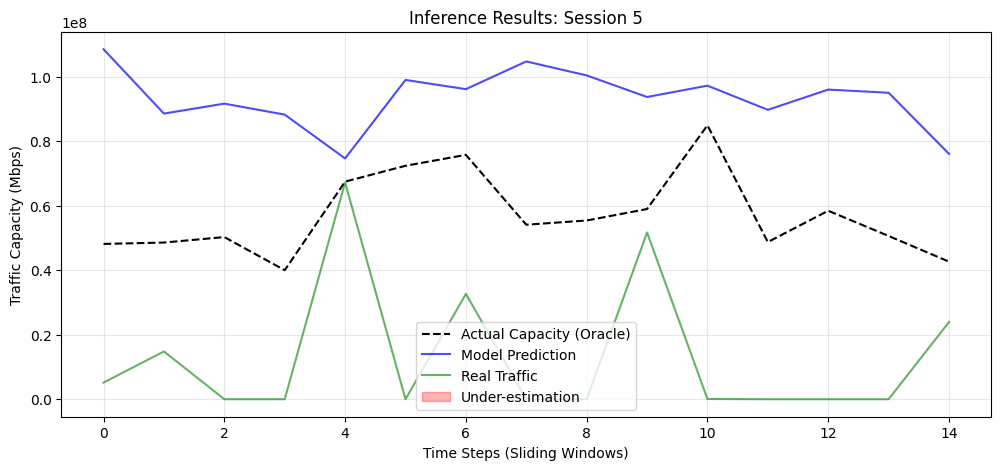


Session Analysis Summary:
Average Absolute Error: 36193048.0000
Under-estimation instances: 0 out of 15


In [14]:

# 1. SETUP FILENAMES
# Replace the suffix with the specific experiment name
suffix = "share-small-BiAtLSTM_task=max_alpha=0.01_seq=82_pred=1_delay=30"

filenames = {
    "preds": f"pred_max_{suffix}.npy",
    "oracle": f"true_oracle_max_{suffix}.npy",
    "true_traj": f"true_future_{suffix}.npy",
    "lengths": f"future_lengths_{suffix}.npy",
    "boundaries": f"window_boundaries_{suffix}.npy"
}

# 2. LOAD DATA
preds = np.load(filenames["preds"])        # Model predictions [N]
oracle = np.load(filenames["oracle"])      # Ground truth Max in future [N]
true_traj = np.load(filenames["true_traj"])# Full future trajectory [N, delay]
lengths = np.load(filenames["lengths"])    # Actual valid steps in trajectory [N]
boundaries = np.load(filenames["boundaries"]) # Session start/end indices [NumSessions, 2]

print(f"Loaded {len(preds)} total windows across {len(boundaries)} sessions.")

# 3. CHOOSE A SESSION
# Let's look at the first session
session_idx = 5
start_idx, end_idx = boundaries[session_idx]

# Slice the global arrays to get only this session's data
s_preds = preds[start_idx:end_idx]
s_oracle = oracle[start_idx:end_idx]
s_traj = true_traj[start_idx:end_idx]
s_lens = lengths[start_idx:end_idx]

print(f"\nAnalyzing Session {session_idx}:")
print(f"Indices in global array: {start_idx} to {end_idx}")
print(f"Number of windows in this session: {len(s_preds)}")

# 4. UNDERSTANDING THE DATA STRUCTURE
# Each 'i' represents a single sliding window (one point in time)
sample_i = 10

print(f"\nDetails for Window #{sample_i} inside Session {session_idx}:")
print(f"Model Predicted (Max for next 30s): {s_preds[sample_i]:.2f}")
print(f"Actual Max that occurred: {s_oracle[sample_i]:.2f}")

# The 'true_traj' contains the actual values for the NEXT 'delay' seconds
actual_sequence = s_traj[sample_i]
valid_len = s_lens[sample_i]
actual_sequence_cleaned = actual_sequence[:valid_len]

print(f"The next {valid_len} seconds of raw traffic values were:")
print(actual_sequence_cleaned)

# 5. QUICK VISUALIZATION
plt.figure(figsize=(12, 5))

# Plotting the Predicted vs Oracle Capacity over the whole session
plt.plot(s_oracle, label="Actual Capacity (Oracle)", color='black', linestyle='--')
plt.plot(s_preds, label="Model Prediction", color='blue', alpha=0.7)
plt.plot(s_traj[:,0],color='green', alpha=0.6, label="Real Traffic")


plt.fill_between(range(len(s_preds)), s_preds, s_oracle,
                 where=(s_preds < s_oracle), color='red', alpha=0.3, label="Under-estimation")

plt.title(f"Inference Results: Session {session_idx}")
plt.xlabel("Time Steps (Sliding Windows)")
plt.ylabel("Traffic Capacity (Mbps)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. HOW TO USE THE DATA FOR ANALYSIS
# Example: Calculate total Under-estimation (Cost) for this session
diff = s_preds - s_oracle
under_est_mask = diff < 0
under_est_count = np.sum(under_est_mask)
avg_error = np.mean(np.abs(diff))

print(f"\nSession Analysis Summary:")
print(f"Average Absolute Error: {avg_error:.4f}")
print(f"Under-estimation instances: {under_est_count} out of {len(s_preds)}")


In [16]:
session_data = true_traj[start_idx:end_idx]
session_preds = preds[start_idx:end_idx]

# DataRate per window (first second of each future window)
traffic_vector = session_data[:, 0]

# GFBR per window
gfbr_vector = session_preds

In [17]:
traffic_vector

array([5.1549040e+06, 1.4802931e+07, 9.3599994e+02, 0.0000000e+00,
       6.7162320e+07, 2.0800000e+02, 3.2644672e+07, 0.0000000e+00,
       0.0000000e+00, 5.1666156e+07, 7.1284000e+04, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.3916228e+07], dtype=float32)

In [18]:
gfbr_vector

array([1.0846449e+08, 8.8518344e+07, 9.1598832e+07, 8.8197712e+07,
       7.4612800e+07, 9.8943040e+07, 9.6092696e+07, 1.0467368e+08,
       1.0035211e+08, 9.3660000e+07, 9.7170776e+07, 8.9683104e+07,
       9.5954520e+07, 9.4978776e+07, 7.6036496e+07], dtype=float32)

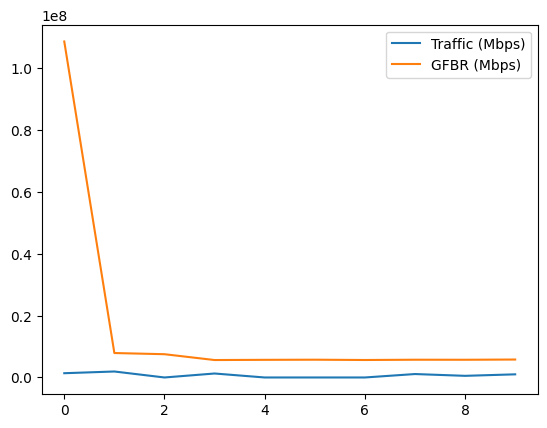

In [22]:
plt.plot(traffic_vector, label="Traffic (Mbps)")
plt.plot(gfbr_vector, label="GFBR (Mbps)")
plt.legend()

In [13]:
gfbr_vector.shape

(15,)